In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True, device_map="tpu:0")

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

In [6]:
def check_if_single_token(token):
    return len(tokenizer.tokenize(token)) == 1

task_name = "es_en"

task = tasks[task_name]

print(len(task))

task = {
    k:v for k,v in task.items() if check_if_single_token(k) and check_if_single_token(v)
}

print(len(task))

pairs = list(task.items())

763
346


In [7]:
import jax

def logprob_loss(logits, tokens, sep=1599, pad_token=32000, n_first=None, shift=None, use_softmax=False):
    if use_softmax:
        logits = jax.nn.log_softmax(logits)
    
    logits = logits[:, :-1]

    # print(
    #     logits.argmax(axis=-1)
    # )

    logits = jnp.take_along_axis(logits, tokens[:, 1:, None], axis=-1).squeeze(-1)

    mask = tokens[:, 1:] == sep
    mask = jnp.cumsum(mask[:, ::-1], axis=-1)[:, ::-1] > 0
    mask = jnp.logical_not(mask)

    if shift is not None:
        rolled_mask = jnp.roll(mask, shift, axis=-1)
        mask = jnp.logical_and(mask, rolled_mask)

    # print(mask[:, -5:])
    
    if n_first is not None:
        rolled_mask = jnp.roll(mask, n_first, axis=-1)
        mask = jnp.logical_and(mask, jnp.logical_not(rolled_mask))

    mask = jnp.logical_and(mask, tokens[:, 1:] != pad_token)

    logits = logits * mask

    return logits.sum(axis=-1).mean(axis=-1)

In [8]:
from functools import partial

sep = 3978
pad = 0

def metric_fn(logits, resids, tokens, use_softmax=False):
    return logprob_loss(logits, tokens, sep=sep, pad_token=pad, n_first=2, use_softmax=use_softmax)

In [9]:
from micrlhf.llama import LlamaBlock, LlamaAttention
from micrlhf.utils.activation_manipulation import ActivationAddition, wrap_vector
from functools import partial
import jax.numpy as jnp
from penzai import pz
import jax

@partial(jax.jit, static_argnames=("metric", "batched"))
def run_with_add(additions_pre, additions_mid, tokens, metric, batched=False, llama=None):
    get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
        pz.nn.Sequential([
            pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
            x
        ])
    )
    get_resids = get_resids.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda l, b: b.select().at_instances_of(pz.nn.Residual).apply_with_selected_index(lambda i, x: x if i == 0 else pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_mid_{l}"),
        x,
    ])))


    get_resids = get_resids.select().at_instances_of(LlamaAttention).apply_with_selected_index(lambda i, x: x.select().at_instances_of(pz.nn.Softmax).apply(lambda b: pz.nn.Sequential([
        b,
        pz.de.TellIntermediate.from_config(tag=f"attn_{i}"),
    ])))

    get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: True)
    make_additions = get_resids.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
        pz.nn.Sequential([
            ActivationAddition(pz.nx.wrap(additions_pre[i], *(("batch",) if batched else ()), "seq", "embedding"), "all"),
            x
        ])
    )
    make_additions = make_additions.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda l, b: b.select().at_instances_of(pz.nn.Residual).apply_with_selected_index(lambda i, x: x if i == 0 else pz.nn.Sequential([
        ActivationAddition(pz.nx.wrap(additions_mid[l], *(("batch",) if batched else ()), "seq", "embedding"), "all"),
        x,
    ])))
    tokens_wrapped = pz.nx.wrap(tokens, "batch", "seq")
    logits, resids = make_additions(llama.inputs.from_basic_segments(tokens_wrapped))
    return metric(logits.unwrap("batch", "seq", "vocabulary"), resids, tokens), (logits, resids[::3], resids[1::3], resids[2::3])


@partial(jax.jit, static_argnames=("metric",))
def get_metric_resid_grad(tokens, llama=llama, metric=metric_fn):
    additions = [jnp.zeros(tokens.shape + (llama.config.hidden_size,)) for _ in range(llama.config.num_layers)]
    batched = tokens.ndim > 1
    (metric, (logits, resids_pre, qk, resids_mid)), (grad_pre, grad_mid) = jax.value_and_grad(run_with_add, argnums=(0, 1), has_aux=True)(additions, additions, tokens, metric, batched=batched, llama=llama)
    return (
        metric,
        [r.value.unwrap("batch", "seq", "embedding") for r in resids_pre],
        [r.value.unwrap("batch", "seq", "embedding") for r in resids_mid],
        [r.value.unwrap("batch", "kv_heads", "q_rep", "seq", "kv_seq") for r in qk],
        grad_pre,
        grad_mid
    )


In [10]:
batch_size = 8 
n_shot=20
max_seq_len = 128
seed = 10

In [11]:
prompt = "Follow the pattern:\n{}"

In [12]:
runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

In [13]:
from sprint.task_vector_utils import tokenized_to_inputs

train_tokens = runner.get_tokens(
    runner.train_pairs, tokenizer
)["input_ids"]

In [14]:
metric_value, resids_pre, resids_mid, qk, grad_pre, grad_mid = get_metric_resid_grad(train_tokens, llama=llama)

In [15]:
get_rms_block = lambda layer, resid_index: (
    llama.select()
    .at_instances_of(LlamaBlock).pick_nth_selected(layer)
    .at_instances_of(pz.nn.Residual).pick_nth_selected(resid_index)
    .at_instances_of(pz.nn.RMSLayerNorm).pick_nth_selected(0)
    ).get()

In [16]:
mlp_rms = [get_rms_block(layer, 1) for layer in range(llama.config.num_layers)]

In [17]:
from micrlhf.utils.load_sae import get_nev_it_sae_suite

In [18]:
from micrlhf.utils.load_sae import weights_to_resid, resids_to_weights

In [19]:
from micrlhf.utils.load_sae import sae_encode_gated

In [20]:
def mlp_normalize(layer, resid_mid):
    # return resid_mid / resids_mid_norms[layer] * mlp_rms_weights[layer]
    # return resid_mid / jnp.linalg.norm(resid_mid, axis=-1, keepdims=True) * mlp_rms_weights[layer]
    return mlp_rms[layer](pz.nx.wrap(resid_mid, "batch", "seq", "embedding")).unwrap("batch", "seq", "embedding")

In [21]:
from tqdm.auto import tqdm

ie_attn = {}
sae_grads_attn = {}
ie_resid = {}
sae_grads_resid = {}
ie_transcoder = {}
sae_grads_transcoder = {}

ie_error_attn = {}
ie_error_resid = {}
ie_error_transcoder = {}

sae_error_attn = {}
sae_error_resid = {}
sae_error_transcoder = {}

def sfc_simple(grad, resid, target, sae):
    pre_relu, post_relu, recon = sae_encode_gated(sae, resid)

    post_relu = post_relu.astype(jnp.float32)
    error = target - recon
    f = partial(weights_to_resid, sae=sae)

    sae_grad, = jax.vjp(f, post_relu)[1](grad,)
    indirect_effects = sae_grad * post_relu
    indirect_effects_error = jnp.einsum("...f, ...f -> ...", grad, error)
    return indirect_effects, indirect_effects_error, sae_grad, error


layers = list(range(6, 17))
for l in tqdm(layers):
    r_pre, r_mid, g_mid = resids_pre[l], resids_mid[l], grad_mid[l]
    sae = get_nev_it_sae_suite(layer=l, label="attn_out")
    indirect_effects, indirect_effects_error, sae_grad, error = sfc_simple(g_mid, r_mid - r_pre, r_mid - r_pre, sae)
    # display((indirect_effects > 0).sum(-1))
    ie_attn[l] = indirect_effects
    ie_error_attn[l] = indirect_effects_error
    sae_grads_attn[l] = sae_grad
    sae_error_attn[l] = error

# for layer, (r_pre, g_pre) in enumerate(zip(resids_pre, grad_pre)):
for l in tqdm(layers):
    r_pre, g_pre = resids_pre[l], grad_pre[l]
    sae = get_nev_it_sae_suite(layer=l)
    indirect_effects, indirect_effects_error, sae_grad, error = sfc_simple(g_pre, r_pre, r_pre, sae)
    # display((indirect_effects != 0).sum(-1))
    ie_resid[l] = indirect_effects
    ie_error_resid[l] = indirect_effects_error
    sae_grads_resid[l] = sae_grad
    sae_error_resid[l] = error

for l in tqdm(layers[:-1]):
    r_mid, r_pre, g_pre = resids_mid[l], resids_pre[l + 1], grad_pre[l + 1]
    sae = get_nev_it_sae_suite(layer=l, label="transcoder")
    indirect_effects, indirect_effects_error, sae_grad, error = sfc_simple(g_pre, mlp_normalize(l, r_mid), r_pre - r_mid, sae)
    # display((indirect_effects != 0).sum(-1))
    ie_transcoder[l] = indirect_effects
    ie_error_transcoder[l] = indirect_effects_error
    sae_grads_transcoder[l] = sae_grad
    sae_error_transcoder[l] = error

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
tokens_wrapped = pz.nx.wrap(train_tokens, "batch", "seq")
llama_inputs = llama.inputs.from_basic_segments(tokens_wrapped)

In [23]:
prompt_length = len(tokenizer.tokenize(prompt))
periods = ["input", "arrow", "output", "newline"]
masks = {
    "prompt": jnp.zeros_like(train_tokens).at[:, :prompt_length].set(1).astype(bool),
    **{
        period: jnp.zeros_like(train_tokens).at[:, prompt_length+i::len(periods)].set(1).astype(bool) * (train_tokens != pad) for i, period in enumerate(periods)
    }
}

In [24]:
def mask_average(vector, mask):
    mask = masks[mask]
    while mask.ndim < vector.ndim:
        mask = mask[..., None]

    return ((mask * vector).sum(1) / mask.sum(1)).mean(0)

In [25]:
@jax.jit
def ablated_metric(llama_ablated):
    ablated_logits = llama_ablated(llama_inputs)
    return metric_fn(ablated_logits.unwrap("batch", "seq", "vocabulary"), None, train_tokens, use_softmax=True)

In [26]:
def mask_ie(ie, threshold):
    out_masks = {}
    total_nodes = 0
    for mask in masks:
        out_masks[mask] = jnp.abs(mask_average(ie, mask)) > threshold
        total_nodes += out_masks[mask].sum()
    return out_masks, total_nodes

In [27]:
from micrlhf.llama import LlamaMLP
from typing import Dict, List
import dataclasses


@pz.pytree_dataclass
class AblatedModule(pz.Layer):
    module: pz.Layer
    sae: dict
    keep_features: Dict[str, jax.typing.ArrayLike]

    @classmethod
    def wrap(self, sae, ablated_features, module=None):
        if module is None:
            module = pz.nn.Identity()
        return AblatedModule(module, sae, ablated_features)

    def __call__(self, x):
        inp = x.unwrap("batch", "seq", "embedding")
        out = self.module(x)
        result = 0
        out = out.unwrap("batch", "seq", "embedding")
        for mask, mask_values in masks.items():
            _, _, recon = sae_encode_gated(self.sae, inp)
            error = out - recon
            _, _, recon_ablated = sae_encode_gated(self.sae, inp, keep_features=self.keep_features[mask])
            res = recon_ablated + error
            res = res * mask_values[..., None]
            result = result + res
        return pz.nx.wrap(result, "batch", "seq", "embedding")


@partial(jax.jit, static_argnames=("ablate_resids",))
def ablate_nodes(threshold, llama, saes, ie_resid, ie_attn, ie_transcoder, ablate_resids=False):
    llama_ablated = llama
    n_nodes = {0: 0}
    for layer in layers:
        block_selection = llama_ablated.select().at_instances_of(LlamaBlock).pick_nth_selected(layer)

        def converter(block):
            n_nodes_resid, n_nodes_attn, n_nodes_mlp = 0, 0, 0

            if ablate_resids:
                try:
                    resid = saes[(layer, "resid")]
                    mask_resid, n_nodes_resid = mask_ie(ie_resid[layer], threshold)
                    block = block.select().at_instances_of(LlamaBlock).apply(lambda x: pz.nn.Sequential([AblatedModule.wrap(resid, mask_resid), x]))
                except KeyError:
                    pass
            try:
                attn_out = saes[(layer, "attn_out")]
                mask_attn_out, n_nodes_attn = mask_ie(ie_attn[layer], threshold)
                block = block.select().at_instances_of(LlamaAttention).apply(lambda x: pz.nn.Sequential([x, AblatedModule.wrap(attn_out, mask_attn_out)]))
            except KeyError:
                pass

            try:
                transcoder = saes[(layer, "transcoder")]
                mask_transcoder, n_nodes_mlp = mask_ie(ie_transcoder[layer], threshold)
                block = block.select().at_instances_of(LlamaMLP).apply(lambda x: AblatedModule.wrap(transcoder, mask_transcoder, x))
            except KeyError:
                pass
            n_nodes[0] += n_nodes_attn + n_nodes_mlp + n_nodes_resid
            return block

        llama_ablated = block_selection.apply(converter)
    return ablated_metric(llama_ablated), n_nodes[0]

In [40]:

saes = {}
for layer in layers:
    try:
        saes[(layer, "attn_out")] = get_nev_it_sae_suite(layer=layer, label="attn_out")
    except KeyError:
        pass
    try:
        saes[(layer, "resid")] = get_nev_it_sae_suite(layer=layer, label="residual")
    except KeyError:
        pass
    try:
        saes[(layer, "transcoder")] = get_nev_it_sae_suite(layer=layer, label="transcoder")
    except KeyError:
        pass

In [41]:
import numpy as np
thresholds = np.linspace(1e-7, 1e-5, 100)
n_nodes_counts = []
ablated_metrics = []
for threshold in tqdm(thresholds):
    abl_met, n_nodes = ablate_nodes(threshold, llama, saes, ie_resid, ie_attn, ie_transcoder, ablate_resids=True)
    ablated_metrics.append(float(abl_met))
    n_nodes_counts.append(int(n_nodes))


  0%|          | 0/100 [00:00<?, ?it/s]

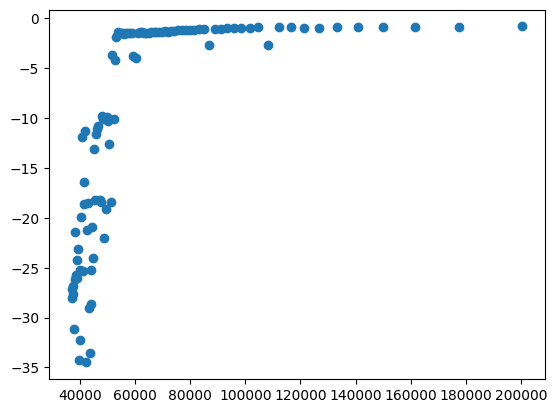

In [42]:
from matplotlib import pyplot as plt
plt.scatter(n_nodes_counts, ablated_metrics)

In [31]:
equality = (xy[:, None, :] < xy[None, :, :]).all(-1)
(equality == equality.T).all()

NameError: name 'xy' is not defined

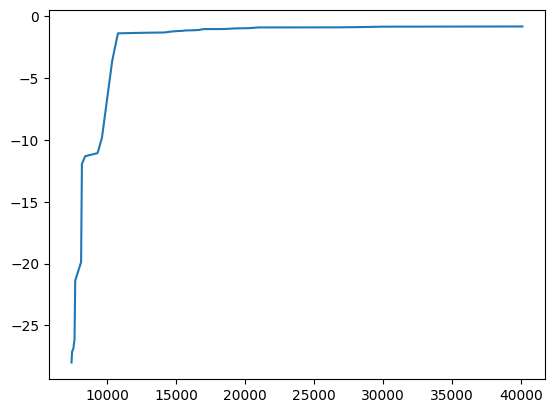

In [43]:
rev = np.array([-1, 1])
xy = np.stack((np.asarray(n_nodes_counts) / len(masks), ablated_metrics), axis=-1) * rev
pareto_mask = ~(xy[:, None, :] < xy[None, :, :]).all(-1).any(axis=1)
pareto = xy[pareto_mask]
# plt.scatter(*(xy[~pareto_mask] * rev).T, c="grey", s=1)
plt.plot(*(pareto * rev).T)
plt.show()


In [37]:
combined_ies = {}
typed_ies = {
    "r": ie_resid,
    "a": ie_attn,
    "t": ie_transcoder,
}

for layer in tqdm(layers):
    for type in typed_ies:
        if layer in typed_ies[type]: 
            ies = typed_ies[type][layer]
            for mask in masks:
                ies_mask = mask_average(ies, mask)
                w, i = jax.lax.top_k(ies_mask, 4)
                for idx, weight in zip(i.tolist(), w.tolist()):
                    combined_ies[(layer, mask, type, idx)] = weight

  0%|          | 0/11 [00:00<?, ?it/s]

In [33]:
# typed_ies_error = {
#     "er": ie_error_resid,
#     "ea": ie_error_attn,
#     "et": ie_error_transcoder,
# }

# for layer in tqdm(layers):
#     for type in typed_ies_error:
#         if layer in typed_ies_error[type]: 
#             ies = typed_ies_error[type][layer]
#             for mask in masks:
#                 ies_mask = mask_average(ies, mask)
#                 # print(ies_mask.tolist())
#                 # raise
#                 combined_ies[(layer, mask, type, 0)] = ies_mask.tolist()

  0%|          | 0/11 [00:00<?, ?it/s]

In [38]:
combined_ies = [
    key + (weight,)
    for key, weight in combined_ies.items()
]

combined_ies = sorted(combined_ies, key=lambda x: -x[-1])

In [39]:
combined_ies[:300]

[(7, 'output', 'r', 23734, 0.008010292425751686),
 (14, 'arrow', 'r', 2092, 0.007372691296041012),
 (13, 'arrow', 'r', 12773, 0.007078766822814941),
 (13, 'arrow', 'r', 6382, 0.006770214531570673),
 (12, 'arrow', 'r', 9157, 0.006260314024984837),
 (14, 'arrow', 'r', 5257, 0.00577723141759634),
 (15, 'arrow', 'r', 23728, 0.005705373361706734),
 (13, 'arrow', 't', 10580, 0.005202464759349823),
 (16, 'arrow', 'r', 24991, 0.005169034935534),
 (9, 'output', 'r', 20228, 0.004866254050284624),
 (16, 'arrow', 'r', 25826, 0.0048441654071211815),
 (11, 'input', 'r', 10452, 0.004710233770310879),
 (16, 'arrow', 'r', 21347, 0.004602901171892881),
 (8, 'output', 'r', 12288, 0.00451873242855072),
 (15, 'arrow', 'r', 25945, 0.004475214518606663),
 (14, 'arrow', 'r', 28960, 0.004443729296326637),
 (8, 'output', 'r', 7158, 0.004408715292811394),
 (12, 'arrow', 't', 11844, 0.004279288463294506),
 (6, 'arrow', 'r', 21082, 0.00423671118915081),
 (16, 'arrow', 'r', 30063, 0.0041780597530305386),
 (12, 'arrow', 'r', 23723, 0.004129108507186174),
 (7, 'arrow', 'r', 411, 0.004020937252789736),
 (14, 'arrow', 'r', 29566, 0.003943555988371372),
 (12, 'arrow', 'r', 19580, 0.00392759358510375),
 (9, 'output', 'r', 10939, 0.003890575375407934),
 (10, 'input', 'r', 15700, 0.0038822132628411055),
 (7, 'output', 'r', 14559, 0.003809806425124407),
 (12, 'arrow', 'r', 1112, 0.003673429600894451),
 (10, 'output', 'r', 1461, 0.003671517362818122),
 (15, 'arrow', 't', 9772, 0.003599874908104539),
 (8, 'input', 'r', 22399, 0.0035788100212812424),
 (6, 'output', 'r', 1, 0.003462937194854021),
 (10, 'output', 'r', 4338, 0.003385821357369423),
 (11, 'arrow', 't', 7583, 0.0033759232610464096),
 (11, 'arrow', 'r', 16172, 0.0033757712226361036),
 (12, 'input', 'r', 17333, 0.0033730491995811462),
 (13, 'arrow', 'r', 26987, 0.0033594262786209583),
 (15, 'arrow', 'r', 14531, 0.003301963210105896),
 (13, 'input', 'r', 28996, 0.0032679191790521145),
 (9, 'arrow', 'r', 2758, 0.0032547791488468647),
 (11, 'arrow', 'a', 23594, 0.0032243398018181324),
 (8, 'output', 'r', 29028, 0.003190606366842985),
 (15, 'arrow', 'r', 13830, 0.003163859946653247),
 (11, 'arrow', 't', 30809, 0.0031234617345035076),
 (13, 'arrow', 'r', 6882, 0.0030430867336690426),
 (13, 'input', 'r', 8977, 0.002977123949676752),
 (11, 'arrow', 'r', 27698, 0.0029671844094991684),
 (7, 'newline', 'r', 411, 0.002891856711357832),
 (7, 'prompt', 'r', 22053, 0.0028890171088278294),
 (9, 'input', 'r', 10591, 0.0028662194963544607),
 (10, 'output', 'r', 23730, 0.002830169629305601),
 (11, 'output', 'r', 5642, 0.002749351318925619),
 (11, 'output', 'r', 27936, 0.0026911855675280094),
 (8, 'prompt', 't', 23850, 0.0026805053930729628),
 (6, 'output', 'r', 27331, 0.0026196546386927366),
 (11, 'output', 'r', 27840, 0.0025476657319813967),
 (12, 'arrow', 't', 7125, 0.0025157718919217587),
 (10, 'arrow', 'r', 8426, 0.0024939258582890034),
 (12, 'input', 'r', 16073, 0.0024436290841549635),
 (6, 'prompt', 'r', 9739, 0.0024419263936579227),
 (7, 'output', 'r', 411, 0.0023708490189164877),
 (6, 'prompt', 'r', 9525, 0.002335483208298683),
 (10, 'input', 'r', 29964, 0.002311856020241976),
 (11, 'arrow', 'r', 20013, 0.002265572315081954),
 (11, 'arrow', 'a', 30066, 0.002216913038864732),
 (11, 'output', 'r', 21543, 0.002214202657341957),
 (11, 'arrow', 't', 11868, 0.0021964104380458593),
 (8, 'arrow', 'r', 8442, 0.002185591496527195),
 (11, 'arrow', 'r', 28800, 0.002160316798835993),
 (7, 'arrow', 'r', 16810, 0.002141046104952693),
 (7, 'input', 'r', 10491, 0.002128812251612544),
 (14, 'arrow', 't', 15161, 0.002096876036375761),
 (13, 'output', 'r', 22551, 0.002079725731164217),
 (14, 'arrow', 't', 5556, 0.002044022548943758),
 (13, 'arrow', 'a', 4745, 0.0020192433148622513),
 (7, 'prompt', 'r', 20254, 0.0019902419298887253),
 (9, 'output', 'r', 15576, 0.0019804509356617928),
 (10, 'output', 'r', 28488, 0.0019658291712403297),
 (11, 'arrow', 'a', 20951, 0.0019267875468358397),
 (11, 'arrow', 'a', 24307, 0.0019093852024525404),
 (9,

In [43]:
with open("node_ies_short.json", "w") as f:
    import json
    json.dump(combined_ies, f)

In [23]:
# def attn_call(layer, resid_pre):
#     subblock = llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(0).get().delta
#     subblock = subblock.select().at_instances_of(LlamaAttention).get()

#     si_selection = subblock.select().at_instances_of(pz.de.HandledSideInputRef)
#     keys = sorted(set([ref.tag for ref in si_selection.get_sequence()]))
#     replaced = si_selection.apply(lambda ref: pz.de.SideInputRequest(tag=ref.tag))
#     subblock = pz.de.WithSideInputsFromInputTuple.handling(replaced, keys)

#     side_inputs = {
#         'positions': llama_inputs.positions,
#         'attn_mask': llama_inputs.attention_mask
#     }
    
#     resid_pre = resid_pre / 

#     resid_pre = pz.nx.wrap(resid_pre, "batch", "seq", "embedding")
#     attn_out = subblock((resid_pre,) + tuple(side_inputs[tag] for tag in subblock.side_input_tags))

#     attn_out = attn_out.unwrap("batch", "seq", "embedding") 

#     return attn_out.astype(resid.dtype)

# attn_call(6, resids_pre[6])

In [26]:
def transcoder_feature_to_mid(layer, feature_idx, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="transcoder")
    resid = resids_mid[layer]

    def f(resid):
        resid = mlp_normalize(layer, resid)
        batch_token_feat = resids_to_weights(resid, sae)[:, :, feature_idx] * sae_grads_transcoder[layer][:, :, feature_idx]
        token_act = mask_average(batch_token_feat, mask)
        return token_act

    return jax.grad(f)(resid)

In [27]:
def transcoder_error_to_mid(layer, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="transcoder")
    resid_next = resids_pre[layer + 1]
    resid = resids_mid[layer]

    grad = grad_pre[layer + 1]

    def f(resid):
        _, _, recon = sae_encode_gated(sae, resid)
        err_by_grad = jnp.einsum("...f, ...f -> ...", (resid_next - recon), grad)
        return mask_average(err_by_grad, mask)

    return jax.grad(f)(resid)

In [28]:
def attn_out_feature_to_pre(layer, feature_idx, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="attn_out")

    resid = resids_pre[layer]

    subblock = llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(0).get().delta

    si_selection = subblock.select().at_instances_of(pz.de.HandledSideInputRef)
    keys = sorted(set([ref.tag for ref in si_selection.get_sequence()]))
    replaced = si_selection.apply(lambda ref: pz.de.SideInputRequest(tag=ref.tag))
    subblock = pz.de.WithSideInputsFromInputTuple.handling(replaced, keys)

    side_inputs = {
        'positions': llama_inputs.positions,
        'attn_mask': llama_inputs.attention_mask
    }

    def f(resid):
        resid = pz.nx.wrap(resid, "batch", "seq", "embedding")
        attn_out = subblock((resid,) + tuple(side_inputs[tag] for tag in subblock.side_input_tags))

        attn_out = attn_out.unwrap("batch", "seq", "embedding") 

        batch_token_feat = resids_to_weights(attn_out, sae)[:, :, feature_idx] * sae_grads_attn[layer][:, :, feature_idx]
        token_act = mask_average(batch_token_feat, mask)
        return token_act

    return jax.grad(f)(resid)

def attn_out_error_to_pre(layer, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="attn_out")

    resid = resids_pre[layer]

    subblock = llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(0).get().delta

    si_selection = subblock.select().at_instances_of(pz.de.HandledSideInputRef)
    keys = sorted(set([ref.tag for ref in si_selection.get_sequence()]))
    replaced = si_selection.apply(lambda ref: pz.de.SideInputRequest(tag=ref.tag))
    subblock = pz.de.WithSideInputsFromInputTuple.handling(replaced, keys)

    side_inputs = {
        'positions': llama_inputs.positions,
        'attn_mask': llama_inputs.attention_mask
    }

    def f(resid):
        resid = pz.nx.wrap(resid, "batch", "seq", "embedding")
        attn_out = subblock((resid,) + tuple(side_inputs[tag] for tag in subblock.side_input_tags))

        attn_out = attn_out.unwrap("batch", "seq", "embedding") 

        _, _, recon = sae_encode_gated(sae, attn_out)
        batch_token_feat = jnp.einsum("...f, ...f -> ...", attn_out - recon, grad_mid[layer])
        token_act = mask_average(batch_token_feat, mask)
        return token_act

    return jax.grad(f)(resid)
# float(jnp.linalg.norm(attn_out_error_to_pre(6, "arrow")))

In [29]:
def pre_feature_to_pre(layer, feature_idx, mask):
    sae = get_nev_it_sae_suite(layer=layer)
    resid = resids_pre[layer]

    def f(resid):
        batch_token_feat = resids_to_weights(resid, sae)[:, :, feature_idx] * sae_grads_resid[layer][:, :, feature_idx]
        token_act = mask_average(batch_token_feat, mask)
        return token_act

    return jax.grad(f)(resid)

def pre_error_to_pre(layer, mask):
    sae = get_nev_it_sae_suite(layer=layer)
    resid = resids_pre[layer]

    def f(resid):
        _, _, recon = sae_encode_gated(sae, resid)
        batch_token_error = jnp.einsum("...f, ...f -> ...", (resid - recon), grad_pre[layer])
        token_grad = mask_average(batch_token_error, mask)
        return token_grad

    return jax.grad(f)(resid)


In [30]:
def ie_pre_to_transcoder_features(layer, grad, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="transcoder")
    resid_mid = resids_mid[layer]
    resid_mid = mlp_normalize(layer, resid_mid)
    ie = sfc_simple(grad, resid_mid, resid_mid, sae)[0]
    ie = mask_average(ie, mask)

    return ie

def ie_pre_to_transcoder_error(layer, grad, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="transcoder")
    resid_next = resids_pre[layer + 1]
    resid_mid = resids_mid[layer]
    ie = sfc_simple(grad, mlp_normalize(layer, resid_mid), resid_next - resid_mid, sae)[1]
    ie = mask_average(ie, mask)

    return ie

In [31]:
def ie_mid_to_attn_features(layer, grad, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="attn_out")
    resid_mid = resids_mid[layer]
    resid_pre = resids_pre[layer]

    ie = sfc_simple(grad, resid_mid - resid_pre, resid_mid - resid_pre, sae)[0]
    ie = mask_average(ie, mask)
    return ie

def ie_mid_to_attn_error(layer, grad, mask):
    sae = get_nev_it_sae_suite(layer=layer, label="attn_out")
    resid_mid = resids_mid[layer]
    resid_pre = resids_pre[layer]

    ie = sfc_simple(grad, resid_mid - resid_pre, resid_mid - resid_pre, sae)[1]
    ie = mask_average(ie, mask)
    return ie

In [32]:
def ie_pre_to_pre_features(layer, grad, mask):
    sae = get_nev_it_sae_suite(layer=layer)
    resid = resids_pre[layer]
    ie = sfc_simple(grad, resid, resid, sae)[0]
    ie = mask_average(ie, mask)
    return ie

def ie_pre_to_pre_error(layer, grad, mask):
    sae = get_nev_it_sae_suite(layer=layer)
    resid = resids_pre[layer]
    ie = sfc_simple(grad, resid, resid, sae)[1]
    ie = mask_average(ie, mask)
    return ie
# float((ie_pre_to_pre_features(6, grad_pre[6], "arrow") - mask_average(ie_error_resid[6], "arrow")).sum())

In [33]:
ie_pre_to_pre_features(6, grad_pre[6], "prompt")

# jax.Array float32(32768,) ≈-1.3e-08 ±2.6e-05 [≥-0.0023, ≤0.0023] zero:32_682 nonzero:86
  Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [33]:
def grad_through_transcoder(layer, grad):
    sae = get_nev_it_sae_suite(layer, label="transcoder")
    resid_mid = resids_mid[layer]

    def f(resid_mid):
        resid_mid = mlp_normalize(layer, resid_mid)
        # we ignore error nodes
        weights = resids_to_weights(resid_mid, sae)
        recon = weights_to_resid(weights, sae)

        return recon

    grad = jax.vjp(f, resid_mid)[1](grad,)[0]

    return grad


In [34]:
def grad_through_mlp(layer, grad):
    mlp = llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(1).get().delta
    resid_mid = resids_mid[layer]
    def f(resid_mid):
        resids_mid = pz.nx.wrap(resid_mid, "batch", "seq", "embedding")
        out = mlp(resids_mid)
        return out.unwrap("batch", "seq", "embedding").astype(resid_mid.dtype)
    return jax.vjp(f, resid_mid)[1](grad.astype(resid_mid.dtype),)[0]

In [35]:
def grad_through_attn(layer, grad):
    subblock = llama.select().at_instances_of(LlamaBlock).pick_nth_selected(layer).at_instances_of(pz.nn.Residual).pick_nth_selected(0).get().delta

    si_selection = subblock.select().at_instances_of(pz.de.HandledSideInputRef)
    keys = sorted(set([ref.tag for ref in si_selection.get_sequence()]))
    replaced = si_selection.apply(lambda ref: pz.de.SideInputRequest(tag=ref.tag))
    subblock = pz.de.WithSideInputsFromInputTuple.handling(replaced, keys)

    side_inputs = {
        'positions': llama_inputs.positions,
        'attn_mask': llama_inputs.attention_mask
    }

    def f(resid):
        resid_pre = pz.nx.wrap(resid, "batch", "seq", "embedding")
        attn_out = subblock((resid_pre,) + tuple(side_inputs[tag] for tag in subblock.side_input_tags))

        attn_out = attn_out.unwrap("batch", "seq", "embedding") 

        return attn_out.astype(resid.dtype)

    resid = resids_pre[layer]
    return jax.vjp(f, resid)[1](grad.astype(resid.dtype),)[0]

In [37]:
ies = ie_resid[12]
ies = mask_average(ies, "arrow")

In [38]:
jax.lax.top_k(ies, 30)

[# jax.Array float32(30,) ≈0.0015 ±0.0014 [≥0.0004, ≤0.0062] nonzero:30
   Array([0.00623179, 0.00412249, 0.00389453, 0.00366905, 0.00362012,
          0.00284077, 0.00281034, 0.00176627, 0.0016341 , 0.00162284,
          0.0014716 , 0.00135594, 0.00130325, 0.00112798, 0.00110467,
          0.00085296, 0.00064201, 0.00059513, 0.0005947 , 0.00057694,
          0.00055326, 0.00054206, 0.00050143, 0.00047176, 0.00045941,
          0.00043115, 0.00042893, 0.00042616, 0.00041728, 0.00039801],      dtype=float32)
 ,
 # jax.Array int32(30,) [≥507, ≤28_260] nonzero:30
   Array([ 9157, 23723, 19580,  1112,   507, 14154, 16983, 13869, 11386,
          28260,  7525, 14214, 16736, 11958, 23598, 19827, 23808, 25169,
           1626,  3310, 11506, 14220, 15223,  6282,  9387, 23657, 21048,
           1727, 21623, 23036], dtype=int32)
 ]

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Selection.get() can only be called on selections with one selected element, but there were 0. Consider using .selected_by_path instead.

In [93]:
float(ablated_metric(llama))

7.7266845703125

In [90]:
r = 0
for k, v in masks.items():
    r = r + v
int(r.max())

1

In [ ]:
def run_with_ablation(ablation_mask):
    